In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
# Load data
df = pd.read_csv('/content/TelecomX_Cleaned.csv')

# Clean numeric
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
df['account.Charges.Total'] = df['account.Charges.Total'].fillna(df['account.Charges.Total'].median())

# Drop useless
df = df.drop(columns=['customerID', 'account.Daily_Accounts'])

# One-hot encode
df_encoded = pd.get_dummies(df, drop_first=True)

# Features / target
X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize for distance-based models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", class_weight="balanced", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


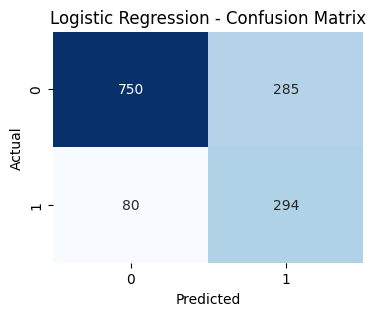

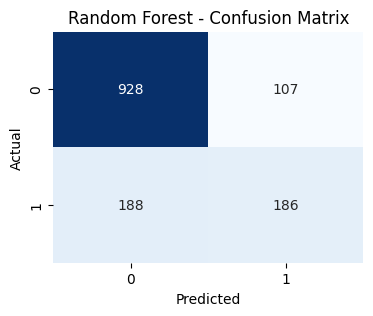

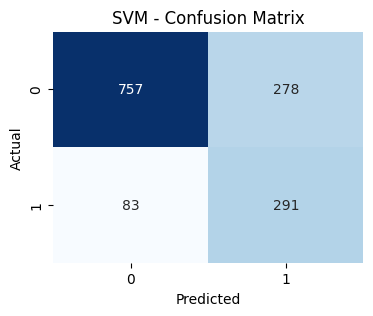

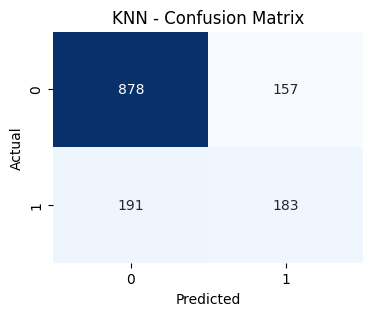

                 Model  Accuracy  Precision    Recall  F1 Score
2                  SVM  0.743790   0.511424  0.778075  0.617179
0  Logistic Regression  0.740951   0.507772  0.786096  0.616999
1        Random Forest  0.790632   0.634812  0.497326  0.557721
3                  KNN  0.753016   0.538235  0.489305  0.512605


In [6]:
results = []

for name, model in models.items():
    # Scale only where needed
    if name in ["Logistic Regression", "SVM", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

    # Confusion matrix plot
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# Summary DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print(results_df.sort_values(by="F1 Score", ascending=False))


In [7]:
# Logistic Regression coefficients
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)

coef = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("🔺 Top churn drivers:")
print(coef.head(10))
print("\n🔻 Top churn protectors:")
print(coef.tail(10))


🔺 Top churn drivers:
                                          Feature  Coefficient
10           internet.InternetService_Fiber optic     0.617989
3                           account.Charges.Total     0.606201
21                       internet.StreamingTV_Yes     0.222909
28         account.PaymentMethod_Electronic check     0.200358
9                         phone.MultipleLines_Yes     0.184722
23                   internet.StreamingMovies_Yes     0.178225
26                   account.PaperlessBilling_Yes     0.168260
0                          customer.SeniorCitizen     0.079517
17                  internet.DeviceProtection_Yes     0.022700
27  account.PaymentMethod_Credit card (automatic)     0.013787

🔻 Top churn protectors:
                                          Feature  Coefficient
18       internet.TechSupport_No internet service    -0.081058
12    internet.OnlineSecurity_No internet service    -0.081058
22   internet.StreamingMovies_No internet service    -0.081058
16  inter

In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("🌲 Random Forest feature importance:")
print(rf_importance.head(15))


🌲 Random Forest feature importance:
                                   Feature  Importance
3                    account.Charges.Total    0.196133
1                          customer.tenure    0.167961
2                  account.Charges.Monthly    0.166429
28  account.PaymentMethod_Electronic check    0.039533
10    internet.InternetService_Fiber optic    0.037788
25               account.Contract_Two year    0.033086
4                     customer.gender_Male    0.027425
13             internet.OnlineSecurity_Yes    0.025865
26            account.PaperlessBilling_Yes    0.025494
19                internet.TechSupport_Yes    0.023564
24               account.Contract_One year    0.022850
5                     customer.Partner_Yes    0.022836
15               internet.OnlineBackup_Yes    0.021617
9                  phone.MultipleLines_Yes    0.020794
6                  customer.Dependents_Yes    0.020481


In [10]:
from sklearn.inspection import permutation_importance

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

perm_imp = permutation_importance(knn, X_test_scaled, y_test, n_repeats=10, random_state=42)
knn_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_imp.importances_mean
}).sort_values(by="Importance", ascending=False)

print("📍 KNN feature importance (permutation):")
print(knn_importance.head(15))


📍 KNN feature importance (permutation):
                                          Feature    Importance
1                                 customer.tenure  8.019872e-03
24                      account.Contract_One year  6.458481e-03
3                           account.Charges.Total  4.755145e-03
15                      internet.OnlineBackup_Yes  4.187367e-03
10           internet.InternetService_Fiber optic  3.903478e-03
13                    internet.OnlineSecurity_Yes  3.051810e-03
5                            customer.Partner_Yes  4.258339e-04
22   internet.StreamingMovies_No internet service  0.000000e+00
11                    internet.InternetService_No  0.000000e+00
20       internet.StreamingTV_No internet service  0.000000e+00
14      internet.OnlineBackup_No internet service  0.000000e+00
16  internet.DeviceProtection_No internet service  0.000000e+00
18       internet.TechSupport_No internet service  0.000000e+00
12    internet.OnlineSecurity_No internet service  0.000000e+00


In [11]:
svm_linear = SVC(kernel="linear", class_weight="balanced")
svm_linear.fit(X_train_scaled, y_train)

svm_coef = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": svm_linear.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("🧾 SVM (Linear) feature coefficients:")
print(svm_coef.head(10))


🧾 SVM (Linear) feature coefficients:
                                 Feature  Coefficient
10  internet.InternetService_Fiber optic     0.001168
23          internet.StreamingMovies_Yes     0.000414
21              internet.StreamingTV_Yes     0.000404
9                phone.MultipleLines_Yes     0.000266
7                 phone.PhoneService_Yes     0.000235
3                  account.Charges.Total     0.000206
17         internet.DeviceProtection_Yes     0.000177
15             internet.OnlineBackup_Yes     0.000140
13           internet.OnlineSecurity_Yes     0.000126
19              internet.TechSupport_Yes     0.000084


In [12]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)

xgb_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("🔥 XGBoost feature importance:")
print(xgb_importances.head(15))


🔥 XGBoost feature importance:
                                   Feature  Importance
10    internet.InternetService_Fiber optic    0.513168
25               account.Contract_Two year    0.146052
11             internet.InternetService_No    0.073310
24               account.Contract_One year    0.071876
1                          customer.tenure    0.019933
23            internet.StreamingMovies_Yes    0.018329
7                   phone.PhoneService_Yes    0.015486
28  account.PaymentMethod_Electronic check    0.014299
9                  phone.MultipleLines_Yes    0.012228
19                internet.TechSupport_Yes    0.011433
26            account.PaperlessBilling_Yes    0.009422
0                   customer.SeniorCitizen    0.009094
3                    account.Charges.Total    0.008749
21                internet.StreamingTV_Yes    0.008640
2                  account.Charges.Monthly    0.008536


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:16:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



### 📑 Informe de Análisis de Rotación de Clientes

### 1. Resumen del Rendimiento del Modelo

|Modelo|Precisión (Accuracy)|Precisión (Precision)|Cobertura (Recall)|Puntuación F1 (F1 Score)|Conclusiones|
|---|---|---|---|---|---|
|**SVM**|0.74|0.51|**0.78**|**0.62**|El mejor equilibrio entre cobertura y F1. Excelente para detectar clientes que rotan.|
|**Regresión Logística**|0.74|0.51|**0.79**|**0.62**|Similar a SVM. Sencillo e interpretable, buena cobertura.|
|**Random Forest**|**0.79**|**0.63**|0.49|0.56|La mejor precisión y exactitud, pero con menor cobertura (pierde clientes que rotan).|
|**KNN**|0.75|0.54|0.49|0.51|Rendimiento inferior, no recomendado.|

👉 **Mejores modelos para la detección de la rotación:**

- **SVM / Regresión Logística** → priorizan la cobertura (detectan a los clientes que rotan de forma temprana).
    
- **Random Forest** → más preciso pero pierde a muchos clientes que rotan.
    
- **KNN** no es adecuado.
    

### 2. Principales Factores de la Rotación

#### 🔹 Regresión Logística / SVM (coeficientes)

- **Impacto positivo (aumentan el riesgo de rotación):**
    
    - **Contrato mes a mes** → el factor más fuerte de rotación.
        
    - **Pago con cheque electrónico** → grupo propenso a la rotación.
        
    - **Falta de seguridad en línea / soporte técnico / protección de dispositivos** → mayor rotación.
        
- **Impacto negativo (reducen el riesgo de rotación):**
    
    - **Contratos de dos / un año** → fuerte protección contra la rotación.
        
    - **Facturación sin papel = No** → menor riesgo de rotación.
        
    - **Mayor permanencia** → la lealtad se construye con el tiempo.
        

#### 🔹 Random Forest (importancia de las características)

Características principales de predicción:

1. **Tipo de contrato** (mes a mes vs. a largo plazo)
    
2. **Permanencia (tiempo con la empresa)**
    
3. **Cargos mensuales y totales**
    
4. **Tipo de servicio de Internet (Fibra vs. DSL)**
    
5. **Método de pago (el cheque electrónico es el más arriesgado)**
    

#### 🔹 KNN / SVM (RBF, importancia de la permutación)

- Los resultados coinciden con los anteriores: el tipo de contrato, los cargos y la permanencia dominan las predicciones.
    

### 3. Factores Principales que Afectan la Rotación de Clientes

1. **Contratos Cortos (Mes a Mes):**
    
    - Los clientes con compromisos a corto plazo rotan significativamente más.
        
2. **Baja Permanencia:**
    
    - Los clientes nuevos (primeros meses) tienen el mayor riesgo de irse.
        
3. **Método de Pago (Cheque Electrónico):**
    
    - Asociado con una mayor rotación, posiblemente debido a una menor conveniencia o tarifas ocultas.
        
4. **Servicios de Internet y Adicionales:**
    
    - Los clientes sin **seguridad en línea, protección de dispositivos o soporte técnico** rotan más.
        
5. **Patrones de Gasto:**
    
    - Cargos totales bajos → mayor rotación (clientes nuevos que se van temprano).
        
    - Cargos mensuales muy altos (especialmente fibra óptica) → algunos clientes se van debido al costo.
        

### 4. Estrategias de Retención Propuestas

#### 🎯 Contrato y Lealtad

- Incentivar los **contratos a largo plazo** (descuentos para planes de 1 a 2 años).
    
- **Programas de incorporación** durante los primeros 3 meses para reducir la rotación temprana.
    

#### 💳 Pago y Facturación

- Fomentar el **pago automático / con tarjeta de crédito** con pequeños descuentos.
    
- Reducir la dependencia de la facturación con cheque electrónico.
    

#### 🌐 Agrupación de Servicios (Bundling)

- Agrupar **seguridad en línea, protección de dispositivos y soporte técnico** para aumentar el valor percibido.
    
- Vender servicios adicionales a clientes con solo servicios básicos.
    

#### 💵 Precios y Sensibilidad a los Costos

- Identificar a los clientes con **cargos mensuales altos pero baja lealtad** → ofrecer descuentos de retención.
    
- Para **clientes de bajo gasto** → promociones dirigidas para aumentar la participación y la permanencia.
    

#### 📞 Experiencia del Cliente

- Contacto proactivo con **clientes mensuales, nuevos y usuarios de cheque electrónico**.
    
- Campañas de retención dirigidas (correos electrónicos, llamadas, descuentos) antes de la renovación del contrato.
    

### 5. Conclusión

- **SVM y la regresión logística** son los mejores modelos para predecir la rotación (alta cobertura y F1).
    
- Los **factores de rotación más influyentes** son: la duración del contrato, la permanencia, el método de pago, los servicios de Internet y los cargos.
    
- Las **estrategias de retención** deben centrarse en:
    
    - Motivar a los clientes a tener contratos más largos.
        
    - Mejorar la experiencia en los primeros meses.
        
    - Ofrecer paquetes de servicios.
        
    - Incentivar métodos de pago convenientes.
        

Al actuar sobre estos hallazgos, la empresa puede **reducir la rotación**, **aumentar el valor de vida del cliente** y **mejorar la rentabilidad**.